# Barebones Kalman filtering

This notebook constructs a few Kalman filters "by hand" using NumPy arrays.

In [1]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt
from scipy import stats

Here we generate some data and a simple Kalman filter for the voltage measurement example from Welch and Bishop (2006).

In [2]:
# Generate some data. True voltages is a standard normal random variable, and remains constant.
# Measurements are normally distributed around the true voltage with a fixed measurement standard deviation.
true_voltage = sp.stats.norm.rvs(0, 2, 1)
measurement_sd = 0.1
N = 100
measurements = true_voltage + sp.stats.norm.rvs(0, 0.1, N)

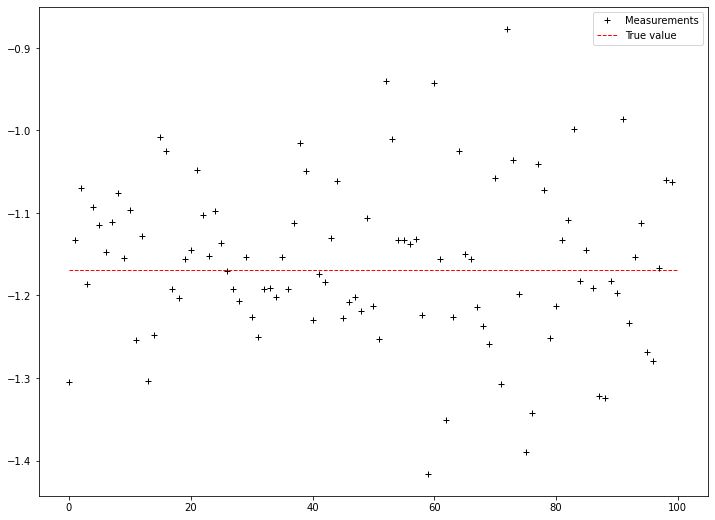

In [3]:
plt.figure(figsize=(12, 9))
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.hlines(y=true_voltage, xmin=0, xmax=N, linestyles='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

The following functions implement the filter update equations. Time update performs the prediction step, while measurement update incorporates the next observation.

In [4]:
def time_update(x, P, Q):
    '''
    Dynamics update for the Kalman filter for the simple voltage estimation problem.
    Parameters:
        x: previous state estimate
        P: previous estimate covariance
        Q: process noise covariance
    Returns: float (prior state estimate), float (prior covariance estimate)
    '''
    return x, P + Q

def measurement_update(x, P, z, R):
    '''
    Measurement update for the Kalman filter for the simple voltage estimation problem.
    Parameters:
        x: state prior estimate
        P: covariance prior estimate
        z: observation
        R: measurement error covariance
    Returns:
        float (posterior state estimate), float (posterior covariance estimate)
    '''
    K = P / (P + R)
    x_new = x + K*(z - x)
    P_new = (1 - K) * P
    return x_new, P_new

def run_voltage_filter(measurements, x_0, P_0, Q, R):
    '''
    Run the Kalman filter for the simple voltage problem.
    Parameters:
        measurements: array of floats, the measured voltages
        x_0: the initial state, aka initial guess
        P_0: the initial covariance estimate
        Q: process noise covariance
        R: the measurement covariance
    Returns: array of floats, the estimated states
    '''
    
    # Set up initial variables
    state_vars = (x_0, P_0)
    state_seq = np.zeros_like(measurements)
    cov_seq = np.zeros_like(measurements)
    state_seq[0] = state_vars[0]
    cov_seq[0] = state_vars[1]
    
    # Run the filter
    for i in range(len(measurements)):
        predicted_state = time_update(state_vars[0], state_vars[1], Q) # Dynamical update step
        corrected_state = measurement_update(predicted_state[0], predicted_state[1], measurements[i], R) # Correction / measurement update
        state_vars = corrected_state
        # Save the computed state and covariance
        state_seq[i] = state_vars[0]
        cov_seq[i] = state_vars[1]
    return state_seq, cov_seq

Let's run the filter with a few different estimates of the error covariance. Tuning R controls how much the filter "trusts" individual measurements -- that is, the weight assigned to the residual component in the update step. If R is underestimated, the filter will assign too much weight to individual measurements, resulting in a noisy estimate and too-high confidence. If R is overestimated, the filter will assign too little weight to measurements, resulting in slow convergence and too-low confidence.

In [5]:
P = 1
Q = 1e-5
R_true = 0.1 ** 2 # The true measurement error covariance
R_low = 0.05 ** 2 # An underestimate of the measurement error covariance
R_high = 2 ** 2 # An overestimate of the measurement error covariance

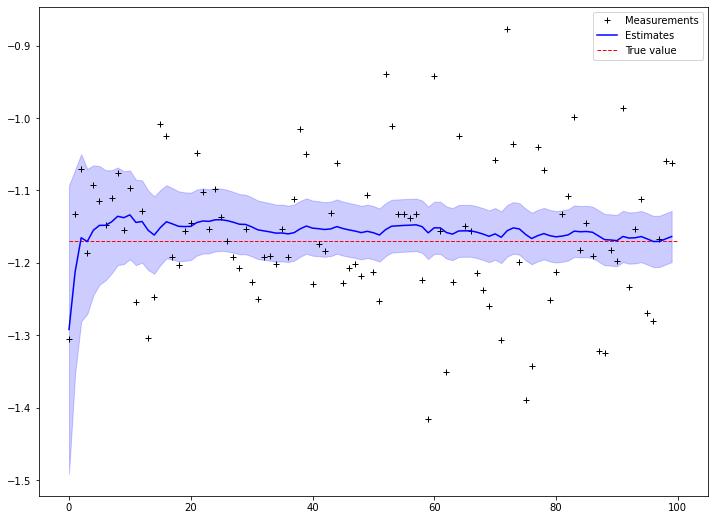

In [6]:
plt.figure(figsize=(12, 9))
states, covs = run_voltage_filter(measurements, 0, P, Q, R_true)
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.plot(range(N), states, 'b', label = 'Estimates')
plt.fill_between(x=range(N), y1=states-2*np.sqrt(covs), y2=states+2*np.sqrt(covs), color='blue', alpha=0.2)
plt.hlines(y=true_voltage, xmin=0, xmax=N, linestyles='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

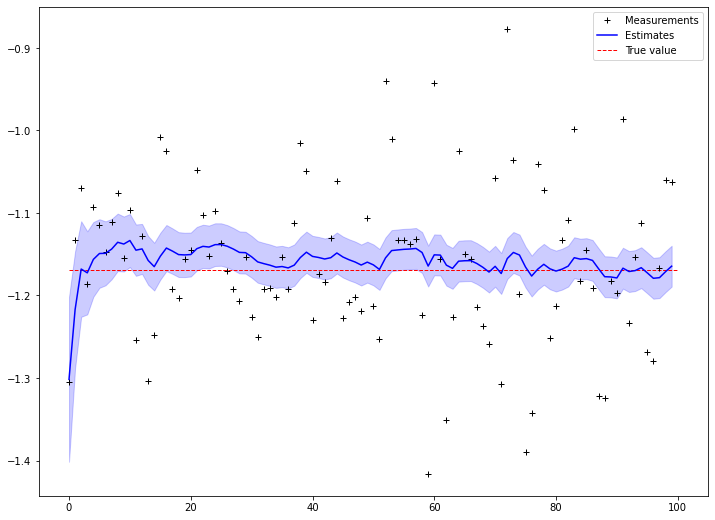

In [7]:
plt.figure(figsize=(12, 9))
states, covs = run_voltage_filter(measurements, 0, P, Q, R_low)
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.plot(range(N), states, 'b', label = 'Estimates')
plt.fill_between(x=range(N), y1=states-2*np.sqrt(covs), y2=states+2*np.sqrt(covs), color='blue', alpha=0.2)
plt.hlines(y=true_voltage, xmin=0, xmax=N, linestyles='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

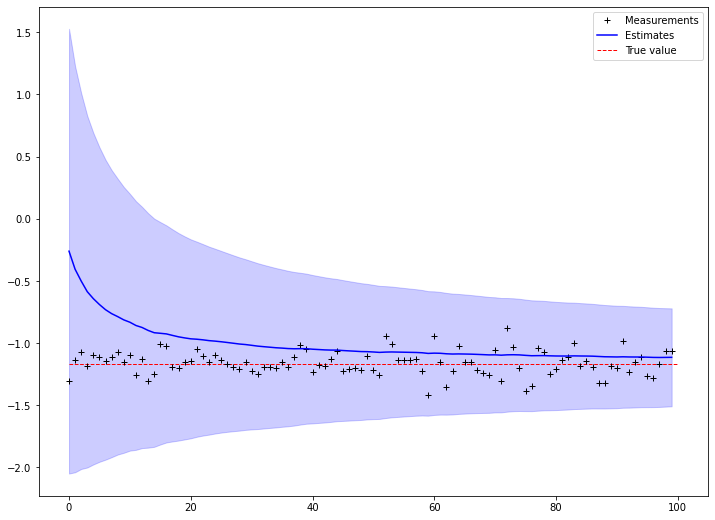

In [8]:
plt.figure(figsize=(12, 9))
states, covs = run_voltage_filter(measurements, 0, P, Q, R_high)
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.plot(range(N), states, 'b', label = 'Estimates')
plt.fill_between(x=range(N), y1=states-2*np.sqrt(covs), y2=states+2*np.sqrt(covs), color='blue', alpha=0.2)
plt.hlines(y=true_voltage, xmin=0, xmax=N, linestyles='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

## A slightly less trivial example

To add a tiny amount of dynamics to this, let's assume the voltage decays from its initial value at a constant rate. This is a simple linear dynamical system, where
$$
x_{t+1} = (1 - r) x_t
$$


In [9]:
decay_rate = 0.02
measurement_sd = 0.1
N = 200
x = np.arange(N)
true_voltage = np.zeros(200)
true_voltage[0] = 0.7
for i in range(1, 200):
    true_voltage[i] = (1 - decay_rate) * true_voltage[i-1]
measurements = true_voltage + sp.stats.norm.rvs(0, 0.1, N)

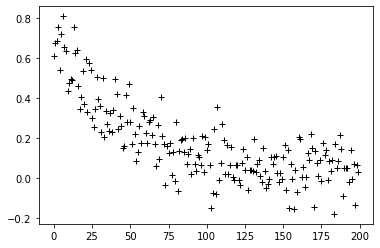

In [10]:
plt.plot(range(N), measurements, 'k+')

We can see that if we run the filter as defined above, it sort of works but it's not great.

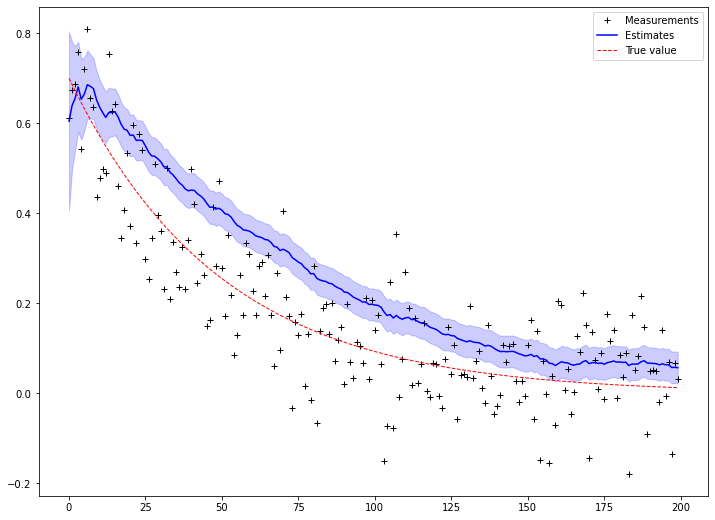

In [11]:
P = 1
Q = 1e-5
R_true = 0.1 ** 2 # The true measurement error covariance
R_low = 0.05 ** 2 # An underestimate of the measurement error covariance
R_high = 2 ** 2 # An overestimate of the measurement error covariance

plt.figure(figsize=(12, 9))
states, covs = run_voltage_filter(measurements, 0, P, Q, R_true)
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.plot(range(N), states, 'b', label = 'Estimates')
plt.fill_between(x=range(N), y1=states-2*np.sqrt(covs), y2=states+2*np.sqrt(covs), color='blue', alpha=0.2)
plt.plot(range(N), true_voltage, ls='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

The problem is that we wrote the filter to estimate a constant, and it doesn't know anything about the dynamics. By incorporating this decay into the update equations, we can correct for this. We only need to redefine time_update.

In [12]:
def time_update(x, P, Q):
    '''
    Dynamics update for the Kalman filter for the simple voltage estimation problem.
    Parameters:
        x: previous state estimate
        P: previous estimate covariance
        Q: process noise covariance
    Returns: float (prior state estimate), float (prior covariance estimate)
    '''
    return (1 - decay_rate) * x, ((1 - decay_rate) ** 2) * P + Q

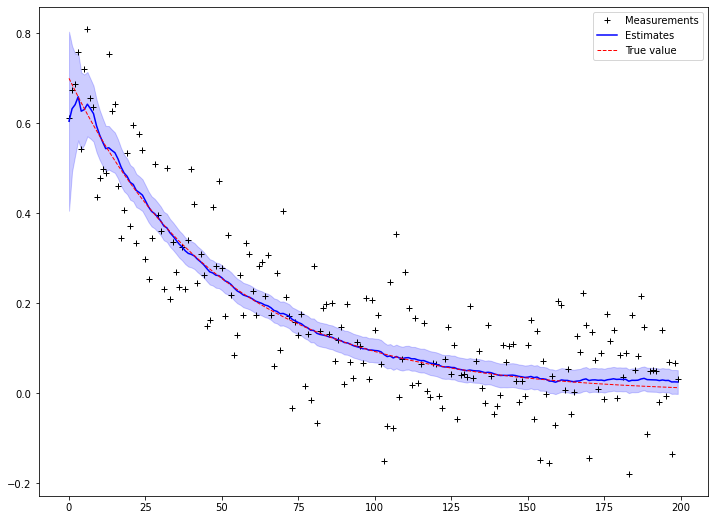

In [13]:
P = 1
Q = 1e-5

plt.figure(figsize=(12, 9))
states, covs = run_voltage_filter(measurements, 0, P, Q, R_true)
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.plot(range(N), states, 'b', label = 'Estimates')
plt.fill_between(x=range(N), y1=states-2*np.sqrt(covs), y2=states+2*np.sqrt(covs), color='blue', alpha=0.2)
plt.plot(range(N), true_voltage, ls='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

What if we don't have a good description of the dynamical system? We can jury-rig a substitute by increasing the process noise covariance:

In [14]:
# Return to the original time_update function
def time_update(x, P, Q):
    '''
    Dynamics update for the Kalman filter for the simple voltage estimation problem.
    Parameters:
        x: previous state estimate
        P: previous estimate covariance
        Q: process noise covariance
    Returns: float (prior state estimate), float (prior covariance estimate)
    '''
    return x, P + Q

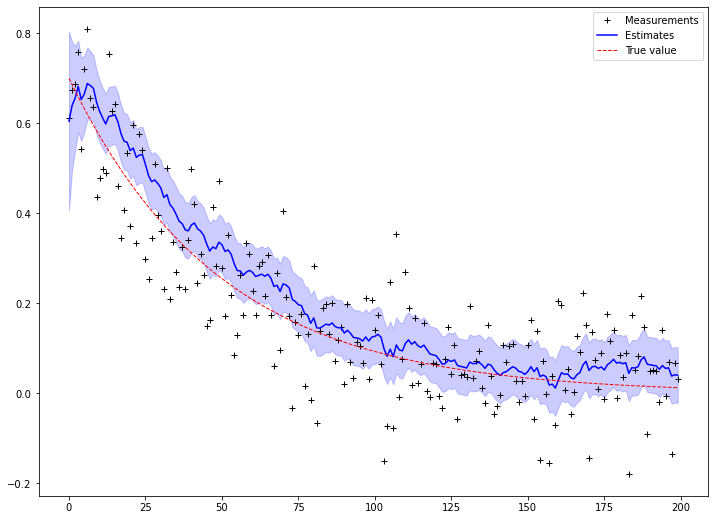

In [15]:
P = 1
Q = 1e-4

plt.figure(figsize=(12, 9))
states, covs = run_voltage_filter(measurements, 0, P, Q, R_true)
plt.plot(range(N), measurements, 'k+', label = 'Measurements')
plt.plot(range(N), states, 'b', label = 'Estimates')
plt.fill_between(x=range(N), y1=states-2*np.sqrt(covs), y2=states+2*np.sqrt(covs), color='blue', alpha=0.2)
plt.plot(range(N), true_voltage, ls='--', lw=1, color = 'red', label = 'True value')
plt.legend()
plt.show()

Why does this work? By increasing the uncertainty in the underlying process, we reduce the confidence in previous estimates, so the filter adapts more to incoming data, at the cost of increasing noise. This can sometimes produce acceptable results if the underlying process cannot be adequately described by the dynamical model, but it's never as good as having an accurate dynamical model.